# EcoFarm Advisor

“Smart Crop & Fertilizer Recommendation System.”

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import requests

sns.set(style="whitegrid")
RANDOM_STATE = 42

## Load the Dataset

In [2]:
df = pd.read_csv("Crop_fertilizer.csv")

print("Dataset Loaded Successfully!")
print("Shape:", df.shape)

# Show first 5 rows
df.head()

Dataset Loaded Successfully!
Shape: (4513, 11)


,District_Name,Soil_color,Nitrogen,Phosphorus,Potassium,pH,Rainfall,Temperature,Crop,Fertilizer,Link
0,Kolhapur,Black,75,50,100,6.5,1000,20,Sugarcane,Urea,https://youtu.be/2t5Am0xLTOo
1,Kolhapur,Black,80,50,100,6.5,1000,20,Sugarcane,Urea,https://youtu.be/2t5Am0xLTOo
2,Kolhapur,Black,85,50,100,6.5,1000,20,Sugarcane,Urea,https://youtu.be/2t5Am0xLTOo
3,Kolhapur,Black,90,50,100,6.5,1000,20,Sugarcane,Urea,https://youtu.be/2t5Am0xLTOo
4,Kolhapur,Black,95,50,100,6.5,1000,20,Sugarcane,Urea,https://youtu.be/2t5Am0xLTOo


## Shuffle Dataset

In [3]:
from sklearn.utils import shuffle

df = shuffle(df, random_state=42).reset_index(drop=True)

df.to_csv("Crop_fertilizer_shuffled.csv", index=False)

print("Shuffled dataset saved as Crop_fertilizer_shuffled.csv")
df.head()

Shuffled dataset saved as Crop_fertilizer_shuffled.csv


,District_Name,Soil_color,Nitrogen,Phosphorus,Potassium,pH,Rainfall,Temperature,Crop,Fertilizer,Link
0,Pune,Reddish Brown,115,50,40,6.5,700,15,Wheat,19:19:19 NPK,https://youtu.be/VNptnPJt5yo
1,Kolhapur,Red,100,80,50,7.0,1000,35,Cotton,DAP,https://www.youtube.com/live/vX-DfTU-KbE?featu...
2,Kolhapur,Red,110,45,55,6.5,900,30,Cotton,DAP,https://www.youtube.com/live/vX-DfTU-KbE?featu...
3,Kolhapur,Red,145,45,75,6.5,1000,35,Cotton,Magnesium Sulphate,https://www.youtube.com/live/vX-DfTU-KbE?featu...
4,Kolhapur,Red,120,70,40,6.0,800,25,Cotton,12:32:16 NPK,https://www.youtube.com/live/vX-DfTU-KbE?featu...


## Drop the "Link" Column

The dataset had an unnecessary column called **Link**.We remove it because it does not help in training the model.

In [4]:
if "Link" in df.columns:
    df.drop("Link", axis=1, inplace=True)
    print("Dropped 'Link' column.")
    
print("Columns now:", df.columns.tolist())

Dropped 'Link' column.
Columns now: ['District_Name', 'Soil_color', 'Nitrogen', 'Phosphorus', 'Potassium', 'pH', 'Rainfall', 'Temperature', 'Crop', 'Fertilizer']


## Check Missing Values & Duplicates

In [5]:
print("Missing values per column:")
print(df.isnull().sum())

dup_count = df.duplicated().sum()
print("\nDuplicate rows:", dup_count)
if dup_count > 0:
    display(df[df.duplicated()].head())


Missing values per column:
District_Name    0
Soil_color       0
Nitrogen         0
Phosphorus       0
Potassium        0
pH               0
Rainfall         0
Temperature      0
Crop             0
Fertilizer       0
dtype: int64

Duplicate rows: 0


## Clean the Dataset

- Removes all duplicate rows.
- Removes rows where important values (N, P, K, pH, Crop) are missing.
- Makes sure we have a clean and usable dataset.

In [6]:
core_cols = []
# try to detect columns - adapt to your CSV column names if different
for name in ["Nitrogen","Phosphorus","Potassium","pH","Crop","Fertilizer","Temperature","Rainfall","District_Name","District","district_name"]:
    if name in df.columns and name not in core_cols:
        core_cols.append(name)

print("Detected some useful columns:", core_cols)

df = df.drop_duplicates().reset_index(drop=True)

required = []
for cand in ["Nitrogen","Phosphorus","Potassium","pH","Crop"]:
    if cand in df.columns:
        required.append(cand)
if len(required) < 5:
    raise ValueError("Dataset missing required core columns. Make sure CSV has Nitrogen, Phosphorus, Potassium, pH, Crop.")

df = df.dropna(subset=required).reset_index(drop=True)

print("Shape after cleaning:", df.shape)

Detected some useful columns: ['Nitrogen', 'Phosphorus', 'Potassium', 'pH', 'Crop', 'Fertilizer', 'Temperature', 'Rainfall', 'District_Name']
Shape after cleaning: (4513, 10)


## Keep Only Useful Columns

In [7]:
keep_cols = [c for c in ["Nitrogen","Phosphorus","Potassium","pH","Crop","Fertilizer","Temperature","Rainfall","District_Name","District"] if c in df.columns]
df = df[keep_cols].copy()
print("Columns kept:", df.columns.tolist())
df.head()

Columns kept: ['Nitrogen', 'Phosphorus', 'Potassium', 'pH', 'Crop', 'Fertilizer', 'Temperature', 'Rainfall', 'District_Name']


,Nitrogen,Phosphorus,Potassium,pH,Crop,Fertilizer,Temperature,Rainfall,District_Name
0,115,50,40,6.5,Wheat,19:19:19 NPK,15,700,Pune
1,100,80,50,7.0,Cotton,DAP,35,1000,Kolhapur
2,110,45,55,6.5,Cotton,DAP,30,900,Kolhapur
3,145,45,75,6.5,Cotton,Magnesium Sulphate,35,1000,Kolhapur
4,120,70,40,6.0,Cotton,12:32:16 NPK,25,800,Kolhapur


## Dataset Summary

- Shows statistics like mean, min, max of each column.
- Shows how many unique crops are present.
- Helps us understand the dataset better.

In [8]:
display(df.describe().T)
print("\nNumber of unique crops:", df["Crop"].nunique())
print(df["Crop"].value_counts().head(15))

,count,mean,std,min,25%,50%,75%,max
Nitrogen,4513.0,95.409927,38.060648,20.0,60.0,105.0,125.0,150.0
Phosphorus,4513.0,54.341901,16.551991,10.0,40.0,55.0,65.0,90.0
Potassium,4513.0,63.595170,35.691911,5.0,40.0,55.0,75.0,150.0
pH,4513.0,6.715267,0.625198,5.5,6.0,6.5,7.0,8.5
Temperature,4513.0,25.915134,5.897328,10.0,20.0,25.0,30.0,40.0
Rainfall,4513.0,819.189010,251.730813,300.0,600.0,800.0,1000.0,1700.0



Number of unique crops: 16
Crop
Sugarcane    1010
Wheat         859
Cotton        650
Jowar         394
Maize         350
Rice          309
Groundnut     177
Tur           126
Grapes        125
Ginger        125
Urad           99
Moong          99
Gram           78
Turmeric       55
Soybean        45
Name: count, dtype: int64


## Histograms

Creates graphs to show how Nutrients (N, P, K) and pH are distributed.

It helps us understand:
- Which nutrients are low/high,
- Whether the data is balanced or skewed.

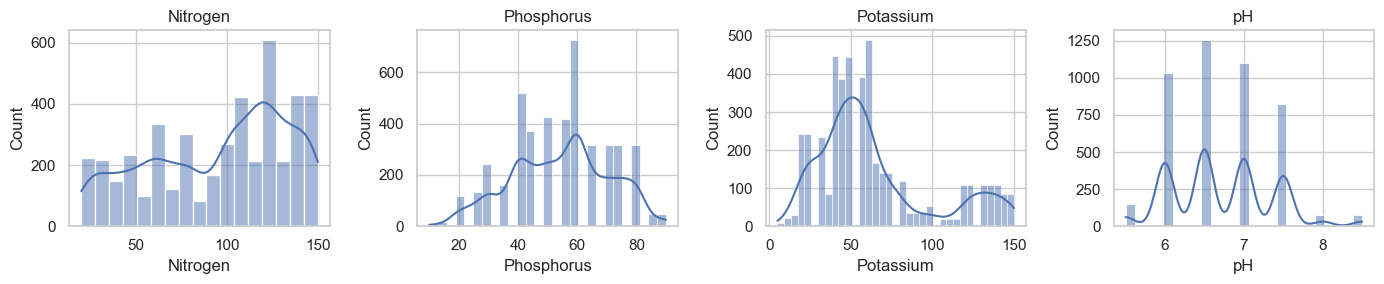

In [9]:
plt.figure(figsize=(14,3))
plt.subplot(1,4,1); sns.histplot(df["Nitrogen"], kde=True); plt.title("Nitrogen")
plt.subplot(1,4,2); sns.histplot(df["Phosphorus"], kde=True); plt.title("Phosphorus")
plt.subplot(1,4,3); sns.histplot(df["Potassium"], kde=True); plt.title("Potassium")
plt.subplot(1,4,4); sns.histplot(df["pH"], kde=True); plt.title("pH")
plt.tight_layout()
plt.show()


## Count Plot of Top Crops

Shows which crops appear most in the dataset.

This helps us see if the dataset is balanced or biased.

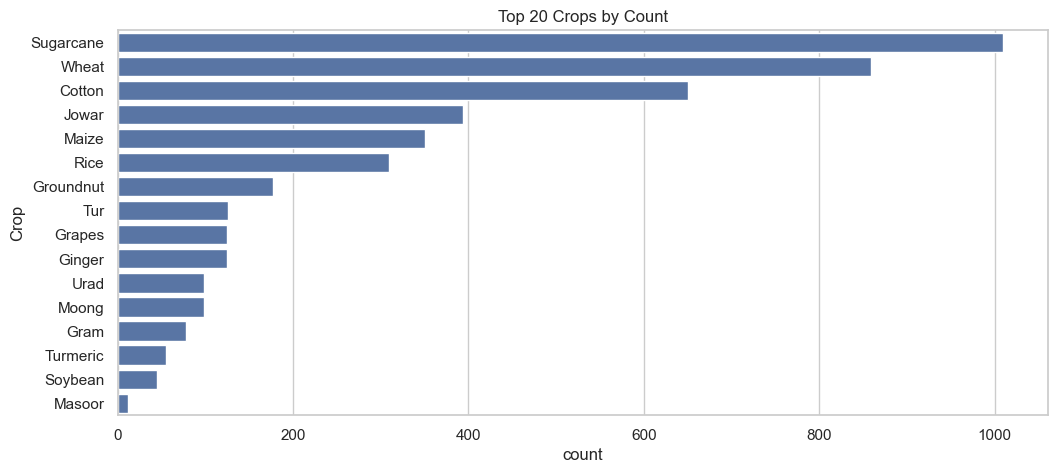

In [10]:
plt.figure(figsize=(12,5))
sns.countplot(y="Crop", data=df, order=df["Crop"].value_counts().index[:20])
plt.title("Top 20 Crops by Count")
plt.show()

## Pairplot EDA

Shows relationship between N, P, K, and pH using scatter plots.

Helps us visually understand patterns between nutrients.

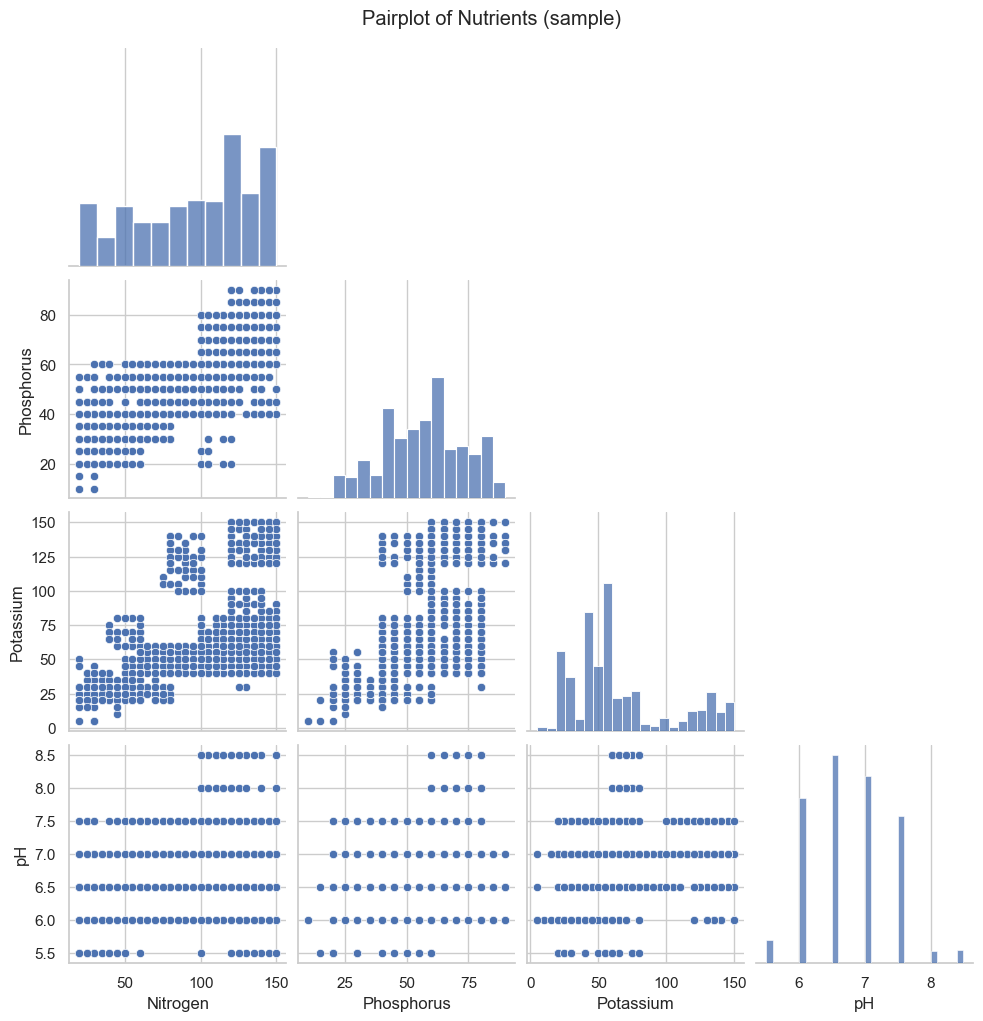

In [11]:
sample_df = df.sample(min(len(df), 1000), random_state=RANDOM_STATE)
sns.pairplot(sample_df[["Nitrogen","Phosphorus","Potassium","pH"]], corner=True)
plt.suptitle("Pairplot of Nutrients (sample)", y=1.02)
plt.show()

## Correlation Heatmap

Shows how strongly nutrients are related to each other.

This helps in feature engineering and model understanding.

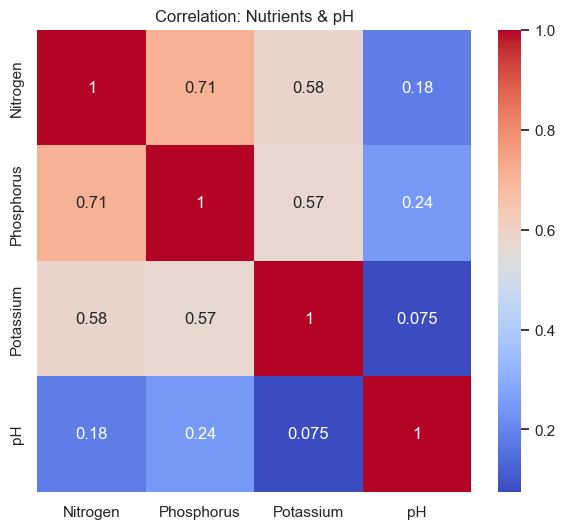

In [12]:
plt.figure(figsize=(7,6))
sns.heatmap(df[["Nitrogen","Phosphorus","Potassium","pH"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation: Nutrients & pH")
plt.show()


## Feature Engineering

Creates new useful features from N, P, K, pH like:
- Total nutrients
- NPK ratio
- Nutrients per pH
- Differences between nutrients
- pH class (Acidic / Neutral / Alkaline)

These new features help improve model accuracy.

In [13]:
df_fe = df.copy()

# numeric ensure
for c in ["Nitrogen","Phosphorus","Potassium","pH"]:
    df_fe[c] = pd.to_numeric(df_fe[c], errors="coerce")

# Derived features
df_fe["Total_Nutrients"] = df_fe["Nitrogen"] + df_fe["Phosphorus"] + df_fe["Potassium"]
df_fe["NPK_Ratio"] = df_fe["Nitrogen"] / (df_fe["Phosphorus"] + df_fe["Potassium"] + 1e-6)
df_fe["N_per_pH"] = df_fe["Nitrogen"] / (df_fe["pH"] + 1e-6)
df_fe["P_per_pH"] = df_fe["Phosphorus"] / (df_fe["pH"] + 1e-6)
df_fe["K_per_pH"] = df_fe["Potassium"] / (df_fe["pH"] + 1e-6)
df_fe["N_minus_P"] = df_fe["Nitrogen"] - df_fe["Phosphorus"]
df_fe["N_minus_K"] = df_fe["Nitrogen"] - df_fe["Potassium"]
df_fe["P_minus_K"] = df_fe["Phosphorus"] - df_fe["Potassium"]

# pH class
df_fe["pH_Class"] = pd.cut(df_fe["pH"], bins=[0,5.5,7,14], labels=["Acidic","Neutral","Alkaline"])
df_fe["pH_Class"] = LabelEncoder().fit_transform(df_fe["pH_Class"].astype(str))

# If Temperature/Rainfall exist, convert numeric
if "Temperature" in df_fe.columns:
    df_fe["Temperature"] = pd.to_numeric(df_fe["Temperature"], errors="coerce")
if "Rainfall" in df_fe.columns:
    df_fe["Rainfall"] = pd.to_numeric(df_fe["Rainfall"], errors="coerce")

df_fe = df_fe.dropna().reset_index(drop=True)
print("After FE shape:", df_fe.shape)
df_fe.head()


After FE shape: (4513, 18)


,Nitrogen,Phosphorus,Potassium,pH,Crop,Fertilizer,Temperature,Rainfall,District_Name,Total_Nutrients,NPK_Ratio,N_per_pH,P_per_pH,K_per_pH,N_minus_P,N_minus_K,P_minus_K,pH_Class
0,115,50,40,6.5,Wheat,19:19:19 NPK,15,700,Pune,205,1.277778,17.692305,7.692307,6.153845,65,75,10,2
1,100,80,50,7.0,Cotton,DAP,35,1000,Kolhapur,230,0.769231,14.285712,11.428570,7.142856,20,50,30,2
2,110,45,55,6.5,Cotton,DAP,30,900,Kolhapur,210,1.100000,16.923074,6.923076,8.461537,65,55,-10,2
3,145,45,75,6.5,Cotton,Magnesium Sulphate,35,1000,Kolhapur,265,1.208333,22.307689,6.923076,11.538460,100,70,-30,2
4,120,70,40,6.0,Cotton,12:32:16 NPK,25,800,Kolhapur,230,1.090909,19.999997,11.666665,6.666666,50,80,30,2


## Prepare Features & Encode Target

Selects which columns will be used for training.
- Converts crop names into numbers using LabelEncoder.
- Prepares X (inputs) and y (output).

In [14]:
features = ["Nitrogen","Phosphorus","Potassium","pH",
            "Total_Nutrients","NPK_Ratio","N_per_pH","P_per_pH","K_per_pH",
            "N_minus_P","N_minus_K","P_minus_K","pH_Class"]

if "Temperature" in df_fe.columns:
    features.insert(4, "Temperature")  # keep temp as early feature
if "Rainfall" in df_fe.columns:
    features.insert(5, "Rainfall")

# final check
features = [f for f in features if f in df_fe.columns]
print("Features used:", features)

le_crop = LabelEncoder()
df_fe["crop_encoded"] = le_crop.fit_transform(df_fe["Crop"].astype(str))

X = df_fe[features].values
y = df_fe["crop_encoded"].values

Features used: ['Nitrogen', 'Phosphorus', 'Potassium', 'pH', 'Temperature', 'Rainfall', 'Total_Nutrients', 'NPK_Ratio', 'N_per_pH', 'P_per_pH', 'K_per_pH', 'N_minus_P', 'N_minus_K', 'P_minus_K', 'pH_Class']


## Train-Test Split

Splits the data into:
- 80% training data
- 20% testing data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)


X_train shape: (3610, 15) X_test shape: (903, 15)


## Scaling (For KNN)

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Train Random Forest Model

In [17]:
rf = RandomForestClassifier(n_estimators=250, max_depth=None, random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
rf

RandomForestClassifier(n_estimators=250, random_state=42)

## Train Decision Tree Model

In [18]:
dt = DecisionTreeClassifier(max_depth=None, random_state=RANDOM_STATE)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
dt_acc = accuracy_score(y_test, y_pred_dt)
dt

DecisionTreeClassifier(random_state=42)

## Train KNN Model

In [19]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
knn_acc = accuracy_score(y_test, y_pred_knn)
knn

KNeighborsClassifier(n_neighbors=7)

## Random Forest Accuracy , Classification Report & Confusion Matrix

=== RANDOM FOREST ===
Accuracy: 0.9413

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       130
           1       1.00      1.00      1.00        25
           2       0.75      0.75      0.75        16
           3       1.00      1.00      1.00        25
           4       0.75      0.69      0.72        35
           5       0.87      0.91      0.89        79
           6       0.99      0.99      0.99        70
           7       1.00      0.50      0.67         2
           8       0.75      0.75      0.75        20
           9       0.98      0.94      0.96        62
          10       1.00      1.00      1.00         9
          11       1.00      1.00      1.00       202
          12       0.80      0.48      0.60        25
          13       0.91      0.91      0.91        11
          14       0.68      0.95      0.79        20
          15       0.97      0.98      0.97       172

    accuracy     

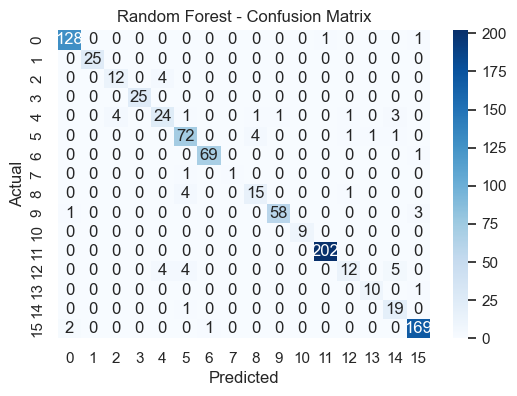

In [20]:
print("=== RANDOM FOREST ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 4))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0))

cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Decision Tree Accuracy ,Classification Report & Confusion Matrix

=== DECISION TREE ===
Accuracy: 0.948

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       130
           1       0.96      1.00      0.98        25
           2       0.72      0.81      0.76        16
           3       1.00      1.00      1.00        25
           4       0.80      0.80      0.80        35
           5       0.96      0.89      0.92        79
           6       0.99      0.97      0.98        70
           7       1.00      1.00      1.00         2
           8       0.83      0.95      0.88        20
           9       1.00      0.95      0.98        62
          10       1.00      1.00      1.00         9
          11       0.99      1.00      1.00       202
          12       0.67      0.56      0.61        25
          13       0.82      0.82      0.82        11
          14       0.75      0.90      0.82        20
          15       0.97      0.99      0.98       172

    accuracy      

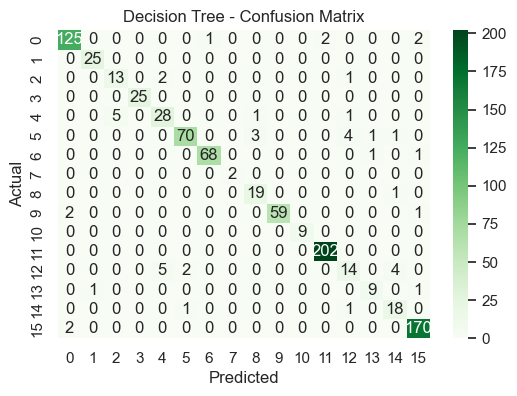

In [21]:
print("=== DECISION TREE ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred_dt), 4))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, zero_division=0))

cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(6,4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens')
plt.title("Decision Tree - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## KNN Accuracy,Classification Report & Confusion Matrix

=== KNN MODEL ===
Accuracy: 0.9125

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       130
           1       0.83      0.96      0.89        25
           2       0.70      0.88      0.78        16
           3       1.00      1.00      1.00        25
           4       0.90      0.80      0.85        35
           5       0.81      0.84      0.82        79
           6       0.99      0.94      0.96        70
           7       0.00      0.00      0.00         2
           8       0.64      0.90      0.75        20
           9       0.95      0.85      0.90        62
          10       0.69      1.00      0.82         9
          11       1.00      1.00      1.00       202
          12       0.89      0.68      0.77        25
          13       1.00      0.45      0.62        11
          14       0.71      0.85      0.77        20
          15       0.92      0.93      0.92       172

    accuracy         

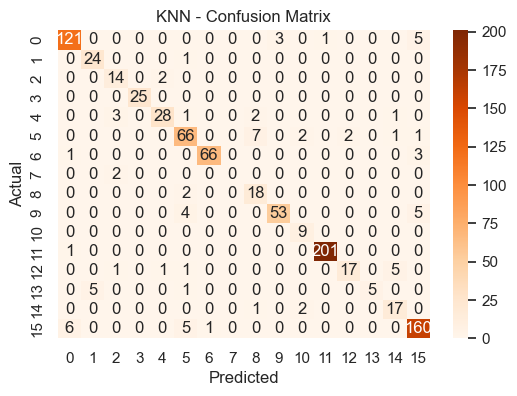

In [22]:
print("=== KNN MODEL ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred_knn), 4))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, zero_division=0))

cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(6,4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Oranges')
plt.title("KNN - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Comparison Table & Best Model Selection

In [23]:
comparison_df = pd.DataFrame({
    "Model": ["RandomForest","DecisionTree","KNN"],
    "Accuracy": [rf_acc, dt_acc, knn_acc]
})
display(comparison_df.sort_values("Accuracy", ascending=False))

best_name = comparison_df.loc[comparison_df["Accuracy"].idxmax(), "Model"]
print("Best model:", best_name)

best_model = {"RandomForest": rf, "DecisionTree": dt, "KNN": knn}[best_name]
# Save scaler too (used for KNN)
artifact = {"model": best_model, "scaler": scaler, "le_crop": le_crop, "features": features}
with open("best_model_artifact.pkl","wb") as f:
    pickle.dump(artifact, f)

,Model,Accuracy
1,DecisionTree,0.947951
0,RandomForest,0.941307
2,KNN,0.912514


Best model: DecisionTree


## Feature Importance

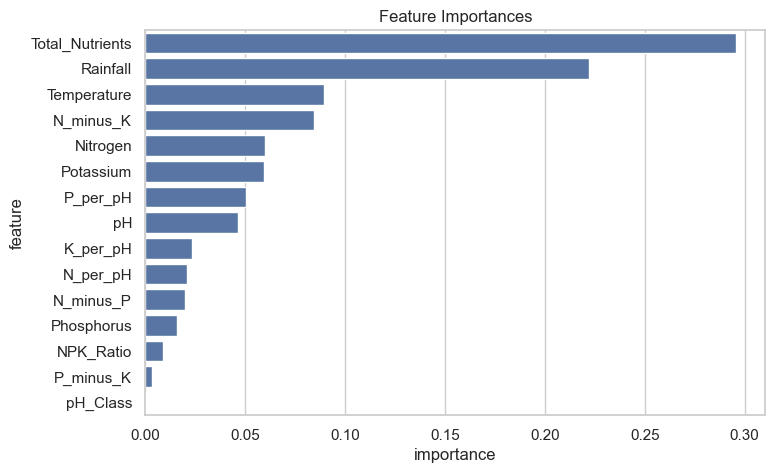

In [24]:
if best_name == "RandomForest" or hasattr(best_model, "feature_importances_"):
    fi = best_model.feature_importances_
    fi_df = pd.DataFrame({"feature": features, "importance": fi}).sort_values("importance", ascending=False)
    plt.figure(figsize=(8,5))
    sns.barplot(x="importance", y="feature", data=fi_df)
    plt.title("Feature Importances")
    plt.show()
else:
    print("Feature importance not available for selected model.")


## Fertilizer Mapping + Organic Alternatives

In [25]:
fert_map = {}
if "Fertilizer" in df_fe.columns:
    for _, r in df_fe.iterrows():
        crop = str(r["Crop"]).strip().lower()
        fert = str(r["Fertilizer"]).strip()
        if fert and fert.lower() != "nan":
            fert_map.setdefault(crop, set()).add(fert)
    fert_map = {k: sorted(list(v)) for k,v in fert_map.items()}

# Simple organic alternative heuristics
organic_alts = {
    "urea": ["well-rotted compost", "farmyard manure", "green manure (legumes)"],
    "dap": ["rock phosphate", "bone meal", "compost + rock phosphate"],
    "mop": ["wood ash", "kelp meal", "composted greens"],
    "npk": ["compost + balanced organic pellet fertilizers", "vermicompost"],
    "default": ["well-rotted compost", "farmyard manure", "green manure"]
}

def get_organic_alternatives(fert_list):
    outs = []
    for f in fert_list:
        fk = f.lower()
        if "urea" in fk or ("n" == fk): outs.append((f, organic_alts["urea"]))
        elif "dap" in fk or "phosphate" in fk: outs.append((f, organic_alts["dap"]))
        elif "mop" in fk or "potash" in fk: outs.append((f, organic_alts["mop"]))
        elif "npk" in fk: outs.append((f, organic_alts["npk"]))
        else: outs.append((f, organic_alts["default"]))
    return outs

## Carbon Emission Estimation

Calculates estimated CO₂ emissions based on:
- Nitrogen usage
- Phosphorus usage
- Potassium usage

Useful for sustainability analysis.

In [26]:
def estimate_carbon_emission(n_amount_kg=0.0, p_amount_kg=0.0, k_amount_kg=0.0, area_hectares=1.0):
    """
    Simple illustrative CO2e estimate (kg) from fertilizer application.
    Replace factors with authoritative sources for production use.
    """
    ef_n = 6.3
    ef_p = 1.5
    ef_k = 0.8
    em_n = n_amount_kg * ef_n
    em_p = p_amount_kg * ef_p
    em_k = k_amount_kg * ef_k
    total = em_n + em_p + em_k
    per_ha = total / area_hectares if area_hectares and area_hectares>0 else None
    return {"total_kg_co2e": total, "breakdown": {"n": em_n, "p": em_p, "k": em_k}, "per_ha_kg_co2e": per_ha}

## API KEY

In [27]:
API_KEY = "279f8f1e5b0fe5fb9d73bd87b15724fd" 

## Live Weather API Function

Fetches real-time weather using district name:
- Temperature
- Humidity
- Rainfall
- Estimated soil moisture

Uses OpenWeatherMap API.

In [28]:
def get_live_weather(district_name):
    url = "https://api.openweathermap.org/data/2.5/weather"
    params = {
        "q": district_name,
        "appid": API_KEY,
        "units": "metric"
    }

    try:
        r = requests.get(url, params=params, timeout=8)
        data = r.json()

        temp = data["main"]["temp"]
        humidity = data["main"]["humidity"]
        rain = data.get("rain", {}).get("1h", 0)

        soil_moisture = round((humidity/100)*0.6 + (rain*0.4), 3)

        return {
            "temperature": temp,
            "humidity": humidity,
            "rainfall_mm": rain,
            "soil_moisture_est": soil_moisture
        }

    except:
        return {"error": "Weather API failed. Check district name."}


## Final Prediction Function

In [29]:
def predict_with_live_weather(n, p, k, ph, district_name, area_hectares=1.0):

    # LIVE WEATHER
    weather = get_live_weather(district_name)
    if "error" in weather:
        return {"error": weather["error"]}

    temp = weather["temperature"]
    rain = weather["rainfall_mm"]

    # Feature engineering (must match training!)
    total = n + p + k
    npk_ratio = n / (p + k + 1e-6)
    n_ph = n / (ph + 1e-6)
    p_ph = p / (ph + 1e-6)
    k_ph = k / (ph + 1e-6)
    n_m_p = n - p
    n_m_k = n - k
    p_m_k = p - k

    if ph <= 5.5: ph_class = 0
    elif ph <= 7: ph_class = 1
    else: ph_class = 2

    # Build feature vector (same order as training)
    feat_vals = []
    for f in features:
        if f == "Nitrogen": feat_vals.append(n)
        elif f == "Phosphorus": feat_vals.append(p)
        elif f == "Potassium": feat_vals.append(k)
        elif f == "pH": feat_vals.append(ph)
        elif f == "Temperature": feat_vals.append(temp)
        elif f == "Rainfall": feat_vals.append(rain)
        elif f == "Total_Nutrients": feat_vals.append(total)
        elif f == "NPK_Ratio": feat_vals.append(npk_ratio)
        elif f == "N_per_pH": feat_vals.append(n_ph)
        elif f == "P_per_pH": feat_vals.append(p_ph)
        elif f == "K_per_pH": feat_vals.append(k_ph)
        elif f == "N_minus_P": feat_vals.append(n_m_p)
        elif f == "N_minus_K": feat_vals.append(n_m_k)
        elif f == "P_minus_K": feat_vals.append(p_m_k)
        elif f == "pH_Class": feat_vals.append(ph_class)
        else:
            feat_vals.append(0.0)

    X_input = np.array([feat_vals])

    # Scale for KNN only
    if isinstance(best_model, KNeighborsClassifier):
        X_input = scaler.transform(X_input)

    # Predict crop
    class_id = best_model.predict(X_input)[0]
    crop_name = le_crop.inverse_transform([class_id])[0]

    # Fertilizers + Organic Alternatives
    fert_list = fert_map.get(crop_name.lower(), ["No fertilizer data available"])
    organic_alt_list = get_organic_alternatives(fert_list)

    # Carbon Emission
    carbon = estimate_carbon_emission(n_amount_kg=n, p_amount_kg=p, k_amount_kg=k, area_hectares=area_hectares)

    return {
        "crop": crop_name,
        "fertilizers": fert_list,
        "organic_alternatives": organic_alt_list,
        "weather": weather,
        "carbon": carbon
    }

## Soil Health Function

In [30]:
def get_soil_health(n, p, k, ph, soil_type):

    health_msg = []

    if n < 60: health_msg.append("Nitrogen: LOW")
    elif n > 120: health_msg.append("Nitrogen: HIGH")
    else: health_msg.append("Nitrogen: OPTIMAL")

    if p < 30: health_msg.append("Phosphorus: LOW")
    elif p > 80: health_msg.append("Phosphorus: HIGH")
    else: health_msg.append("Phosphorus: OPTIMAL")

    if k < 30: health_msg.append("Potassium: LOW")
    elif k > 80: health_msg.append("Potassium: HIGH")
    else: health_msg.append("Potassium: OPTIMAL")

    if ph < 5.5: health_msg.append("Soil pH: ACIDIC")
    elif ph > 7.5: health_msg.append("Soil pH: ALKALINE")
    else: health_msg.append("Soil pH: NEUTRAL (GOOD)")

    return {
        "soil_health_report": health_msg,
        "soil_type": soil_type
    }


## User Input Function

In [31]:
def user_input_pipeline():

    print("\n========= ENTER SOIL DETAILS =========")

    n = float(input("Enter Nitrogen (N): "))
    p = float(input("Enter Phosphorus (P): "))
    k = float(input("Enter Potassium (K): "))
    ph = float(input("Enter Soil pH: "))
    soil_type = input("Enter Soil Type (Red/Black/Clay/etc.): ")
    district = input("Enter District Name: ")

    # Soil Health
    soil_health = get_soil_health(n, p, k, ph, soil_type)

    # Prediction + Weather + Fertilizers
    result = predict_with_live_weather(
        n=n, p=p, k=k, ph=ph, district_name=district
    )

    print("\n================== OUTPUT ==================")

    print("\n🌱 SOIL HEALTH:")
    for msg in soil_health["soil_health_report"]:
        print(" -", msg)
    print(" - Soil Type:", soil_health["soil_type"])

    print("\n🌾 RECOMMENDED CROP:", result["crop"])

    print("\n🧪 RECOMMENDED FERTILIZERS:")
    for f in result["fertilizers"]:
        print(" -", f)

    print("\n🌿 ORGANIC ALTERNATIVES:")
    for fert, alts in result["organic_alternatives"]:
        print(f" - For {fert}:")
        for a in alts:
            print("     •", a)

    print("\n⛅ LIVE WEATHER:")
    w = result["weather"]
    print(" - Temperature:", w["temperature"], "°C")
    print(" - Humidity:", w["humidity"], "%")
    print(" - Rainfall:", w["rainfall_mm"], "mm")
    print(" - Soil Moisture:", w["soil_moisture_est"])

    print("\n🌍 CARBON EMISSION:")
    c = result["carbon"]
    print(" - Total CO₂e:", c["total_kg_co2e"], "kg")
    print(" - Per hectare:", c["per_ha_kg_co2e"], "kg/ha")

    print("===========================================\n")

## Call Input Function

In [32]:
user_input_pipeline()


========= ENTER SOIL DETAILS =========


Enter Nitrogen (N):  40
Enter Phosphorus (P):  50
Enter Potassium (K):  30
Enter Soil pH:  2.5
Enter Soil Type (Red/Black/Clay/etc.):  Red
Enter District Name:  Pune



================== OUTPUT ==================

🌱 SOIL HEALTH:
 - Nitrogen: LOW
 - Phosphorus: OPTIMAL
 - Potassium: OPTIMAL
 - Soil pH: ACIDIC
 - Soil Type: Red

🌾 RECOMMENDED CROP: Gram

🧪 RECOMMENDED FERTILIZERS:
 - 18:46:00 NPK
 - DAP
 - MOP
 - Sulphur

🌿 ORGANIC ALTERNATIVES:
 - For 18:46:00 NPK:
     • compost + balanced organic pellet fertilizers
     • vermicompost
 - For DAP:
     • rock phosphate
     • bone meal
     • compost + rock phosphate
 - For MOP:
     • wood ash
     • kelp meal
     • composted greens
 - For Sulphur:
     • well-rotted compost
     • farmyard manure
     • green manure

⛅ LIVE WEATHER:
 - Temperature: 19.49 °C
 - Humidity: 62 %
 - Rainfall: 0 mm
 - Soil Moisture: 0.372

🌍 CARBON EMISSION:
 - Total CO₂e: 351.0 kg
 - Per hectare: 351.0 kg/ha



## Save Model

In [33]:
import pickle

# Create model artifact for Decision Tree
model_artifact = {
    "model": dt,                    # your trained Decision Tree model
    "scaler": scaler,               # saved only for compatibility (not used by DT)
    "label_encoder": le_crop,       # converts numeric prediction → crop name
    "features": features,           # exact feature order used in training
    "fertilizer_map": fert_map,     # crop → fertilizer mapping
    "organic_alts": organic_alts    # organic alternatives dictionary
}

# Save as pickle file
with open("final_crop_model.pkl", "wb") as f:
    pickle.dump(model_artifact, f)

print("Decision Tree model saved as final_crop_model.pkl")


Decision Tree model saved as final_crop_model.pkl
